# Lab 6: Graphical Models

Welcome to the advanced Machine Learning Course.

The objective of this lab session is to code a few regression algorithms and to apply them to synthetic and real datasets.

Please put **"ML - MDS - TD6"** in the mail subject or I might lose your work (which means 0) and send it to pierre.houdouin@centralesupelec.fr

Please label your notebook **"L6_familyname1_familyname2.ipynb"** or I might lose your work (which means 0).

We begin with the standard imports:

In [174]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
from tqdm import tqdm
import networkx as nx
import scipy

In [190]:
class my_GLasso():
    
    def __init__(self, lambd=0.01, mu=0.01, max_iter = 60):
        '''
        Parameters:
        lambd : float
            Penalization parameter selected.
        nu: float>0

        Attributes:
        
        covariance_ : numpy.ndarray, shape (n_features, n_features)
            Estimated covariance matrix.
        precision_ : numpy.ndarray, shape (n_features, n_features)
            Estimated precision matrix (inverse covariance).
        '''
        self.mean = None
        self.covariance_ = None
        self.precision_ = None
        self.lambd = lambd
        self.mu = mu
        self.max_iter = max_iter

        self.tol = 1e-6


    def set_mean(self,X):
        self.mean = np.mean(X, axis=0)
    def set_S(self, X):
        n,p = X.shape
        self.S =(1/n) * (X - self.mean).T @ (X - self.mean) #+ np.eye(X.shape[1]) * 1e-6
    
    def random_symmetric_semi_definite_matrix(self, n, seed=None):
        if seed is not None:
            np.random.seed(seed)  # For reproducibility
        
        # Generate a random matrix B
        B = np.random.rand(n, n)
        
        # Compute the symmetric positive semi-definite matrix S
        S = np.dot(B, B.T) #+ np.eye(B.shape[0]) * 1e-6
    
        return S 

    def phi(self, L, epsilon=1e-6):
        # Soft thresholding with a small constant to prevent zeroing out values
        return np.diag((L + np.sqrt(L**2 + 4/self.mu + epsilon)) / 2)


    def fit(self, X):
        """ Fits the GraphicalLasso model to X. """
        # Initialize
        p = X.shape[1]
        self.set_mean(X)
        self.set_S(X)

        # Initialize P, Z, V (Identity matrix for P, zero matrices for Z and V)
        P = np.eye(p)  # Better initialization (identity matrix)
        Z = 0.01 * np.random.randn(p, p)
        V = 0.01 * np.random.randn(p, p)

        for k in range(self.max_iter):
            # Update step for P
            T = -V + Z - (1/self.mu) * self.S
            eig_vals, U = np.linalg.eigh(T)
            P = U @ self.phi(eig_vals) @ U.T

            # Thresholding step for Z
            threshold = np.maximum(0, np.abs(P + V) - self.lambd / self.mu)
            Z_new = np.sign(P + V) * threshold

            # Check convergence of Z and P (primal residual)
            primal_residual = np.linalg.norm(P - Z_new, ord='fro')
            dual_residual = np.linalg.norm(V, ord='fro')

            # Print residuals to monitor progress
            # print(f"Iteration {k} | Primal Residual: {primal_residual} | Dual Residual: {dual_residual}")

            # Convergence check: if residuals are sufficiently small, stop
            if primal_residual < self.tol and dual_residual < self.tol:
                print(f'Converged at iteration {k}')
                break

            # Update Z and V
            Z = Z_new
            V = V + self.mu * (P - Z)

        # Save results
        self.precision_ = P
        self.covariance_ = np.linalg.inv(P)
        self.Z_ = Z
        self.V_ = V
        return self



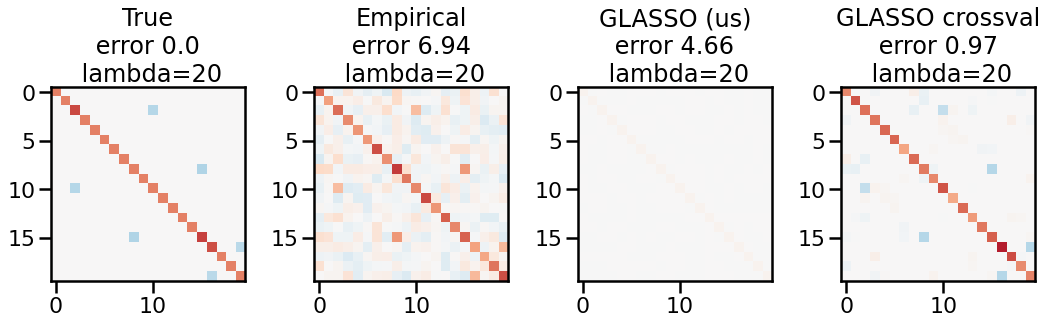

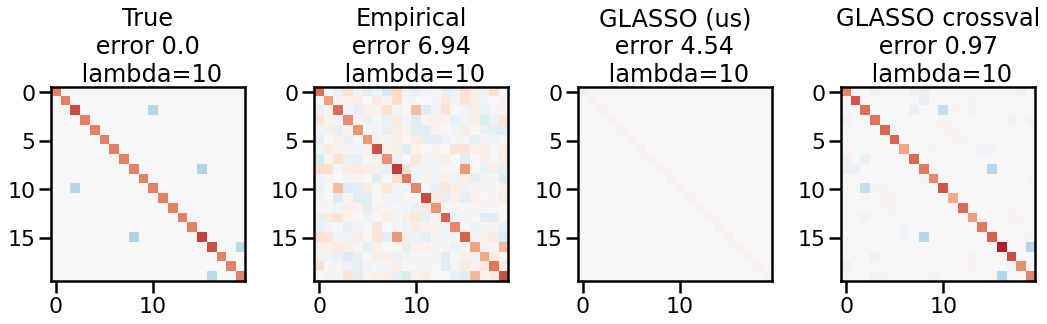

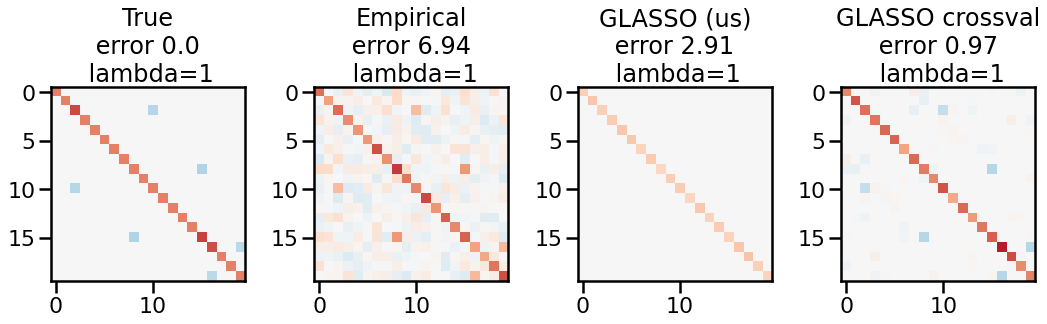

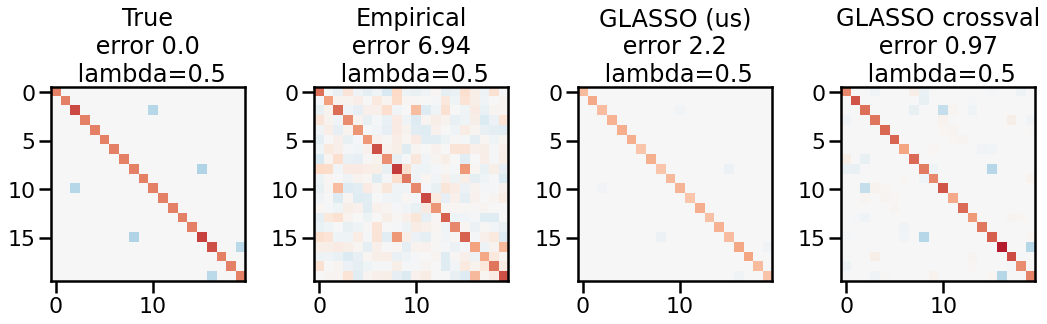

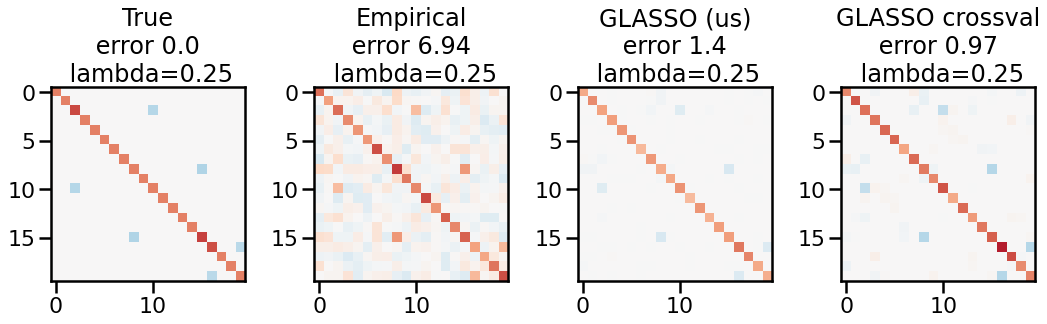

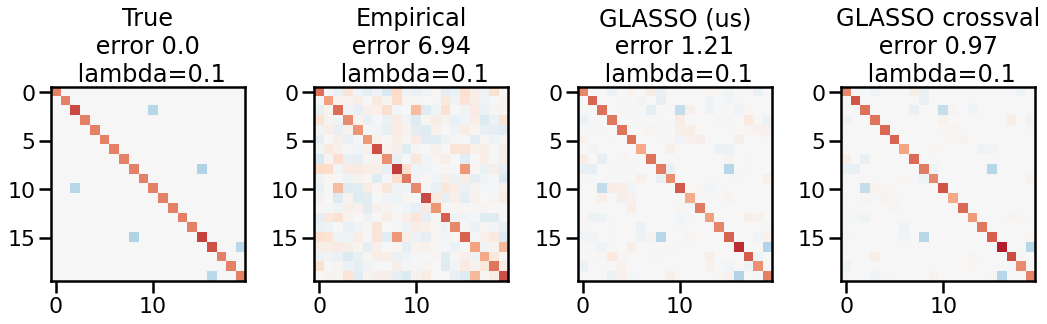

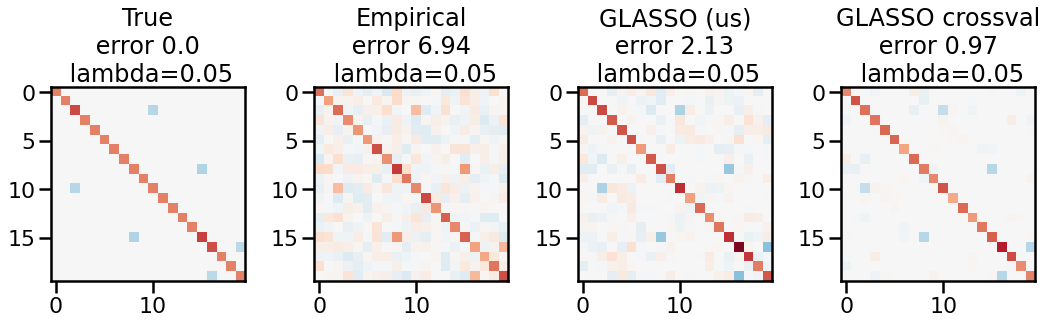

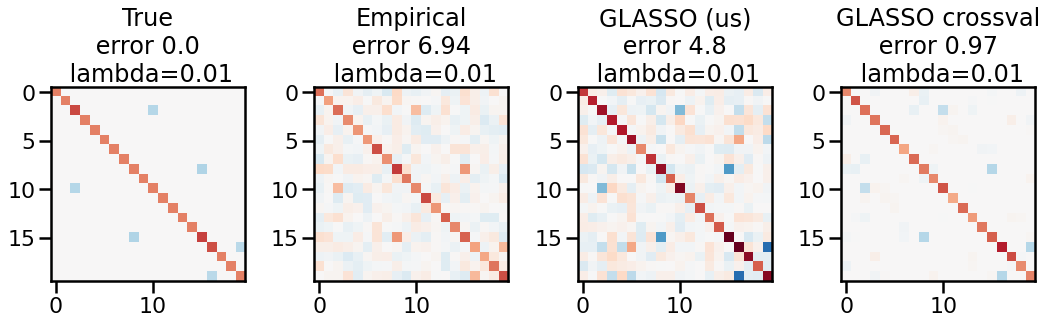

In [191]:
from sklearn.covariance import GraphicalLassoCV
from sklearn.datasets import make_sparse_spd_matrix

# TODO : Compare methods of estimating the covariance matrix in low-sample regime
n_samples = 60
n_features = 20

# Simulate data (multivariate gaussian)

rng = np.random.RandomState(1)
prec = make_sparse_spd_matrix(n_features, alpha=.98, smallest_coef=.4, largest_coef=.7, random_state=rng)
cov = np.linalg.inv(prec)
mean = np.zeros(n_features)
data = np.random.multivariate_normal(mean, cov, n_samples)
err = np.linalg.norm(prec - prec)

prec_empirical = np.linalg.inv(np.dot(data.T, data) / n_samples)
err_empirical = np.linalg.norm(prec - prec_empirical)

lambda_value = [20, 10,1,0.5,0.25,0.1, 0.05, 0.01]

for lambd in lambda_value:
    # Scikit-learn Graphical Lasso with cross validation 


    model_skl = GraphicalLassoCV()
    model_skl.fit(data)
    prec_glassocv = model_skl.precision_
    err_glassocv = np.linalg.norm(prec_glassocv - prec)

    # Get the estimated precision matrix (inverse covariance)

    model_us = my_GLasso(lambd, max_iter=500, mu=0.5)
    model_us.fit(data)
    prec_glasso = model_us.precision_
    err_glasso = np.linalg.norm(prec_glasso - prec)

    # Graphical Lasso estimation using our implementation

    # Visual comparison
    titles = ["True", "Empirical", "GLASSO (us)", "GLASSO crossval"]
    imgs = [prec, model_us.S, prec_glasso, prec_glassocv]
    errors = [err, err_empirical, err_glasso, err_glassocv]

    vmax = 2

    ncols = len(titles)
    fig, axes = plt.subplots(1, ncols, figsize=(15, 5))
    for idx, ax in enumerate(axes.flatten()):
        img = imgs[idx]
        error = np.around(errors[idx], decimals=2)
        title = titles[idx] + f'\n error {error} \n lambda={lambd}'
        ax.imshow(img, vmin=-vmax, vmax=vmax, interpolation='nearest', cmap=plt.cm.RdBu_r)
        ax.set_title(title)
    fig.tight_layout()

In [187]:
model_skl.tol

0.0001

### Nodewise Regression

Fill in the following class that implements the nodewise regression algorithm to estimate a graphical model structure. You can use `LassoCV` for the regressions. Bonus (not graded): Implement your own cross-validation lasso.

In [171]:
import numpy as np
from sklearn.linear_model import LassoCV

class my_nodewise_regression():
    
    def __init__(self, rule='AND', eps=1e-8):
        '''
        Parameters:
        rule: {"OR", "AND"}
            Rule for determining adjacency from regression coefficients.
        eps: float
            Threshold for considering coefficients nonzero.
        
        Attributes:
        graph_structure_ : numpy.ndarray, shape (n_features, n_features)
            Estimated adjacency matrix.        
        '''
        self.graph_structure_ = None
        self.rule = rule
        self.eps = eps
        
    def fit(self, X):
        """ Fit the model to X.
        
        Parameters:
        -----------
        X: (n_samples, n_features) np.array
            Data matrix.
        
        Returns:
        --------
        self
        """         
        n_samples, n_features = X.shape
        adjacency_matrix = np.zeros((n_features, n_features))
        
        # Perform nodewise regression for each variable
        for j in range(n_features):
            # Target variable
            y = X[:, j]
            
            # Features (excluding column j)
            X_j = np.delete(X, j, axis=1)
            
            # Lasso regression
            lasso = LassoCV(cv=5).fit(X_j, y)
            coefs = lasso.coef_
            
            # Insert coefficients into the adjacency matrix
            adjacency_matrix[j, :] = np.insert(coefs, j, 0)  # Re-insert zero at diagonal
        
        # Apply symmetry rule
        if self.rule == "AND":
            graph_structure = np.minimum(adjacency_matrix, adjacency_matrix.T)  # Element-wise minimum
        elif self.rule == "OR":
            graph_structure = np.maximum(adjacency_matrix, adjacency_matrix.T)  # Element-wise maximum
        else:
            raise ValueError("Invalid rule. Choose 'AND' or 'OR'.")
        
        # Threshold small coefficients
        self.graph_structure_ = (np.abs(graph_structure) > self.eps).astype(int)
        
        return self


In [172]:
np.random.seed(1)
n = 5000
p = 6
epsilon=1e-1
X = np.random.randn(n, p)
X.T[1] += X.T[0]
X.T[2] += X.T[1]
real_graph_structure = np.zeros((p, p))
real_graph_structure[0,1] = 1
real_graph_structure[1,0] = 1
real_graph_structure[1,2] = 1
real_graph_structure[2,1] = 1

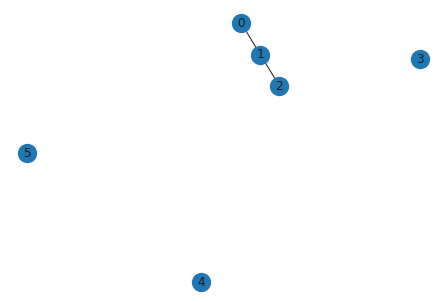

In [186]:
import networkx as nx

# Assuming real_graph_structure is your numpy array or matrix
nx_real = nx.from_numpy_array(real_graph_structure.T)
nx.draw(nx_real, with_labels=True)


We notice that the initial graph is **poorly connected**, there are a lot of conditional independances between the components.

When we will reconstruct the graph with the predicted value of the precision matrix, **we expect higher values for the conditional correlation between nodes 0, 1 and 2**. 

However, based on what we saw before, we must expect a complete graph if we dont specify a minimum weight for the edges to be taken into account.

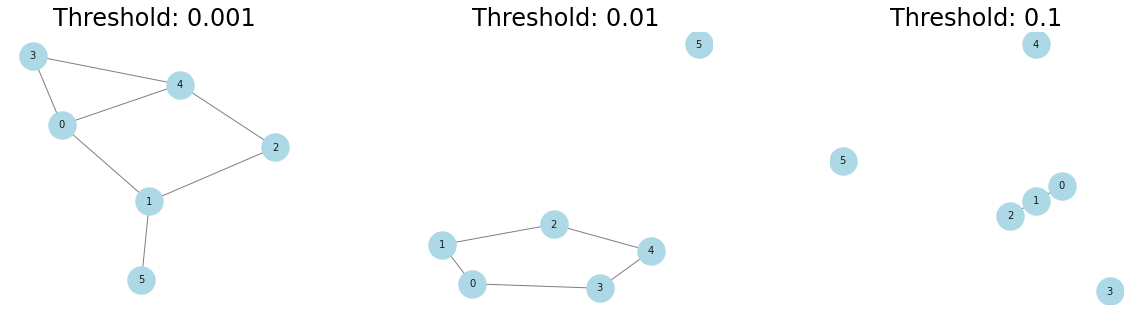

In [178]:
#TODO : plot the reconstructed graph with GLASSO using different thresholds. Comment the impact of the choice of the threshold
# Run GLASSO (Graphical Lasso CV)
glasso = GraphicalLassoCV()
glasso.fit(X)
precision_matrix = glasso.precision_

# Define thresholds
thresholds = [0.001, 0.01, 0.1]

# Plot reconstructed graphs for different thresholds
fig, axes = plt.subplots(1, len(thresholds), figsize=(20, 5))

for idx, threshold in enumerate(thresholds):
    # Threshold the precision matrix to create adjacency matrix
    adj_matrix = (np.abs(precision_matrix) > threshold).astype(int)
    np.fill_diagonal(adj_matrix, 0)  # Remove self-loops
    
    # Create graph
    G = nx.from_numpy_array(adj_matrix)
    
    # Plot graph
    ax = axes[idx]
    nx.draw(
        G, ax=ax, with_labels=True, node_color='lightblue', edge_color='gray',
        node_size=700, font_size=10
    )
    ax.set_title(f"Threshold: {threshold}")

fig.subplots_adjust(wspace=0.4)
plt.show()

C:\Users\emili\AppData\Local\Temp\ipykernel_1444\3606057812.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


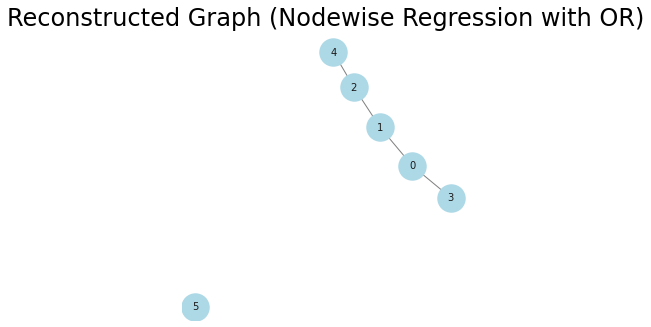

In [179]:
#TODO : plot the reconstructed graph with nodewise regression using the rule OR
# Fit Nodewise Regression with "OR" rule
model = my_nodewise_regression(rule='OR')
model.fit(X)
adj_matrix = model.graph_structure_

# Visualize the reconstructed graph
plt.figure(figsize=(4, 4))
nx_reconstructed = nx.from_numpy_array(adj_matrix)
nx.draw(nx_reconstructed, with_labels=True, node_color='lightblue', edge_color='gray', node_size=700, font_size=10)
plt.title("Reconstructed Graph (Nodewise Regression with OR)")
plt.tight_layout()
plt.show()

C:\Users\emili\AppData\Local\Temp\ipykernel_1444\519619763.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


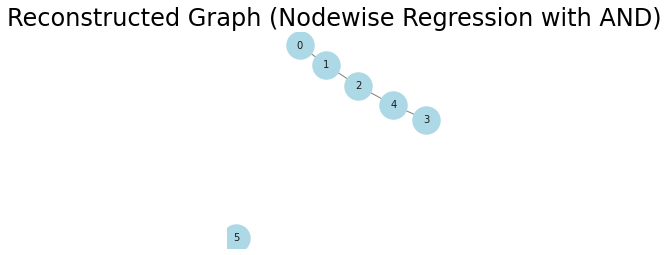

In [180]:
#TODO : plot the reconstructed graph with nodewise regression using the rule AND
# Fit Nodewise Regression with "OR" rule
model = my_nodewise_regression(rule='AND')
model.fit(X)
adj_matrix = model.graph_structure_

# Visualize the reconstructed graph
plt.figure(figsize=(3, 3))
nx_reconstructed = nx.from_numpy_array(adj_matrix)
nx.draw(nx_reconstructed, with_labels=True, node_color='lightblue', edge_color='gray', node_size=700, font_size=10)
plt.title("Reconstructed Graph (Nodewise Regression with AND)")
plt.tight_layout()
plt.show()

## Simulations

Compare the two graph estimators for each of the following models with $p = 300$ and $n = 40, 80, 320$:

- An AR(1)-Block model. In this model the *covariance* matrix is block-diagonal with equalsized AR(1)-blocks of the form $(\Sigma_{Block})_{i, j} = 0.9^{|i−j|}$, take $30 \times 30$ blocks.
- The exponential decay model considered in Fan et al. [2009]. In this model we consider a case where no element of the concentration matrix is exactly zero. The elements of $\Theta$ are given by $\Theta_{ij} = \exp{(−2|i − j|)}$ equals essentially zero when the difference |i − j| is large.

For GLasso estimation, use cross-validation k-fold with loglikelihood loss to select the $\lambda$ penalization parameter. Evaluate your estimation using the Froebenius matrix norm. 

For Node-regression estimation, compare your edge-estimation with the binary (thresholded) covariance matrix. Evaluate your estimation using accuracy and the F1 score. 